## Section 1: Imports and Configuration
### Importing necessary libraries for data manipulation, visualization, and model building.

In [2]:
# Cassava Leaf Disease Classification

## Overview
# This notebook implements a classification model using EfficientNetB0 to detect leaf diseases from cassava images. The dataset contains five disease classes.

# Section 1: Imports and Configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
from PIL import Image

# Configuration settings
class CFG:    
    WORK_DIR = "../input/cassava-leaf-disease-classification/"
    BATCH_SIZE = 8
    EPOCHS = 10
    TARGET_SIZE = 256
    NCLASSES = 5

# Utility functions
def visualize_class_distribution(labels):
    plt.figure(figsize=(8, 6))
    sns.countplot(x='label', data=labels, palette='coolwarm')
    plt.title('Class Distribution', fontsize=16)
    plt.xlabel('Disease Classes', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.tight_layout()
    plt.show()

def load_and_display_sample_image(image_dir, image_id, label):
    sample_image_path = os.path.join(image_dir, image_id)
    sample_image = Image.open(sample_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(sample_image)
    plt.title(f"Sample Image - Class: {label}")
    plt.axis('off')
    plt.show()

def create_data_generators(labels, image_dir):
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rotation_range=45,
        zoom_range=0.2,
        shear_range=0.15,
        brightness_range=[0.8, 1.2],
        channel_shift_range=50.0,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=image_dir,
        subset="training",
        x_col="image_id",
        y_col="label",
        target_size=(CFG.TARGET_SIZE, CFG.TARGET_SIZE),
        batch_size=CFG.BATCH_SIZE,
        class_mode="sparse",
        seed=42
    )

    validation_datagen = ImageDataGenerator(
        validation_split=0.2,
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=image_dir,
        subset="validation",
        x_col="image_id",
        y_col="label",
        target_size=(CFG.TARGET_SIZE, CFG.TARGET_SIZE),
        batch_size=CFG.BATCH_SIZE,
        class_mode="sparse",
        shuffle=False,
        seed=42
    )

    return train_generator, validation_generator

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, generator, class_indices):
    val_preds = model.predict(generator).argmax(axis=1)
    val_true = generator.classes

    # Classification report
    report = classification_report(val_true, val_preds, target_names=class_indices.keys())
    print(report)

    # Confusion matrix
    cm = confusion_matrix(val_true, val_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return val_preds, val_true

def plot_roc_curve(model, generator, class_indices):
    val_true_bin = label_binarize(generator.classes, classes=list(class_indices.values()))
    pred_probs = model.predict(generator)

    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_indices.keys()):
        fpr, tpr, _ = roc_curve(val_true_bin[:, i], pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Multi-Class ROC Curve', fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

## Section 2: Load and Explore Data
### Load the dataset and explore its structure to understand the data.

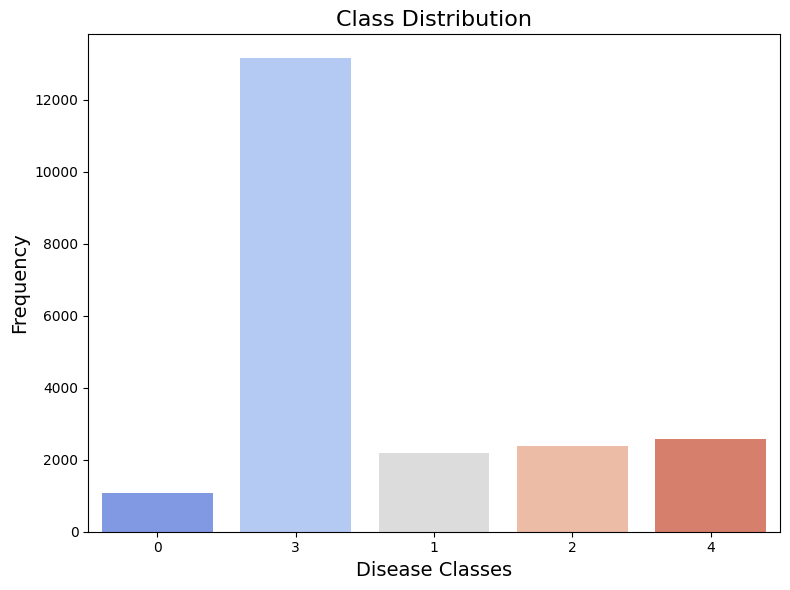

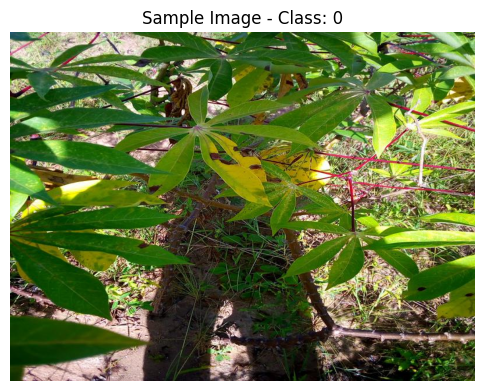

In [4]:
train_labels = pd.read_csv(os.path.join(CFG.WORK_DIR, "train.csv"))
train_labels['label'] = train_labels['label'].astype(str)

# Visualize class distribution
visualize_class_distribution(train_labels)

# Display sample image
image_dir = os.path.join(CFG.WORK_DIR, "train_images")
load_and_display_sample_image(image_dir, train_labels['image_id'][0], train_labels['label'][0])

## Section 3: Data Preprocessing
### Preprocessing includes normalizing pixel values and augmenting the dataset to improve model generalization.

In [5]:
train_generator, validation_generator = create_data_generators(train_labels, image_dir)

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


## Section 4: Model Creation
### Define the EfficientNetB0 model architecture and prepare it for training.

In [6]:
# Section 4: Model Creation
def create_model():
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(CFG.TARGET_SIZE, CFG.TARGET_SIZE, 3))
    x = layers.GlobalAveragePooling2D()(base_model.output)
    output = layers.Dense(CFG.NCLASSES, activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 4,013,953 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [7]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels['label']), y=train_labels['label'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 3.9368905243790246, 1: 1.954956601187757, 2: 1.7935456831517183, 3: 0.3252317981456148, 4: 1.6606131160263873}


## Section 5: Model Training
### Train the model using the training and validation data generators.

In [8]:
# Section 5: Model Training
callbacks = [
    ModelCheckpoint('best_model.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min',verbose = 1),
    EarlyStopping(monitor='val_loss',min_delta = 0.001, patience=5,mode = 'min',verbose = 1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2,min_delta = 0.001, 
                              mode = 'min', verbose = 1)
]

STEPS_PER_EPOCH = int(len(train_labels)*0.8 / CFG.BATCH_SIZE)
VALIDATION_STEPS = int(len(train_labels)*0.2 / CFG.BATCH_SIZE)

history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=CFG.EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1738274709.256865     131 service.cc:145] XLA service 0x7da3fc0030a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738274709.256938     131 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   2/2139 ━━━━━━━━━━━━━━━━━━━━ 2:09 61ms/step - accuracy: 0.3438 - loss: 1.2546   

I0000 00:00:1738274756.221515     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2139/2139 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.5077 - loss: 1.3453
Epoch 1: val_loss improved from inf to 1.41108, saving model to best_model.weights.h5
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 633s 257ms/step - accuracy: 0.5077 - loss: 1.3452 - val_accuracy: 0.5307 - val_loss: 1.4111 - learning_rate: 0.0010
Epoch 2/10
   1/2139 ━━━━━━━━━━━━━━━━━━━━ 2:01 57ms/step - accuracy: 0.6250 - loss: 0.4977

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.41108
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6250 - loss: 0.4977 - val_accuracy: 0.7143 - val_loss: 1.5374 - learning_rate: 0.0010
Epoch 3/10
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.6425 - loss: 1.0503
Epoch 3: val_loss improved from 1.41108 to 0.73986, saving model to best_model.weights.h5
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 404s 188ms/step - accuracy: 0.6425 - loss: 1.0503 - val_accuracy: 0.7341 - val_loss: 0.7399 - learning_rate: 0.0010
Epoch 4/10
   1/2139 ━━━━━━━━━━━━━━━━━━━━ 1:49 51ms/step - accuracy: 0.8750 - loss: 0.5844
Epoch 4: val_loss improved from 0.73986 to 0.26202, saving model to best_model.weights.h5
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 1s 392us/step - accuracy: 0.8750 - loss: 0.5844 - val_accuracy: 1.0000 - val_loss: 0.2620 - learning_rate: 0.0010
Epoch 5/10
2139/2139 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.6925 - loss: 0.9453
Epoch 5: val_loss did not improve from 0.26202
2139/2139 ━━━━━━━━━

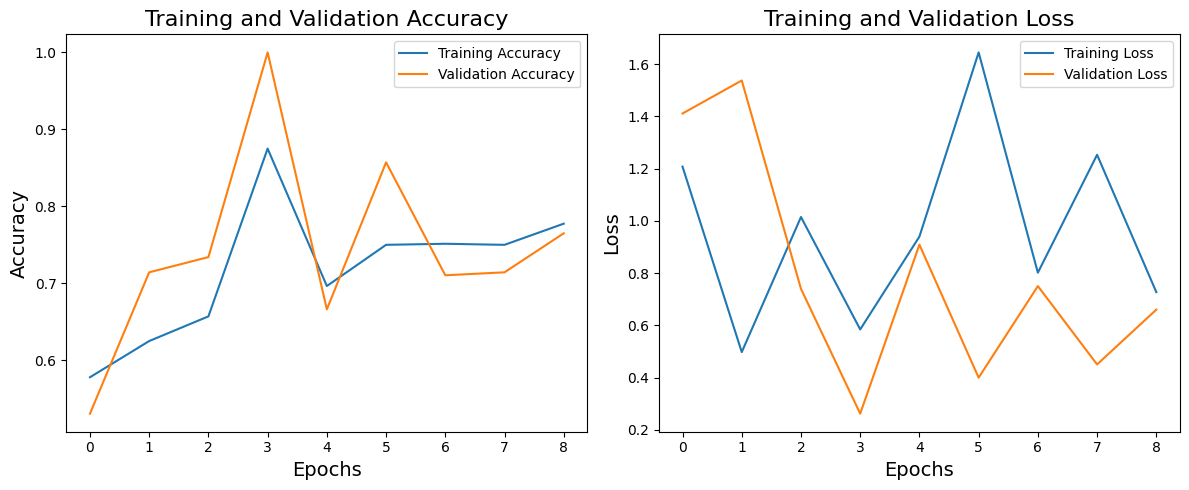

In [9]:
plot_training_history(history)

## Section 6: Model Evaluation and Predictions
### Evaluate the trained model and make predictions on the test data.

535/535 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step
              precision    recall  f1-score   support

           0       0.37      0.80      0.51       200
           1       0.68      0.63      0.65       436
           2       0.57      0.68      0.62       495
           3       0.97      0.78      0.86      2638
           4       0.45      0.64      0.53       510

    accuracy                           0.74      4279
   macro avg       0.61      0.71      0.63      4279
weighted avg       0.80      0.74      0.76      4279



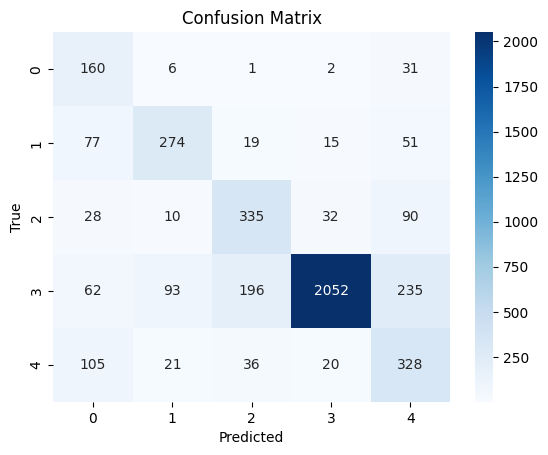

535/535 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step


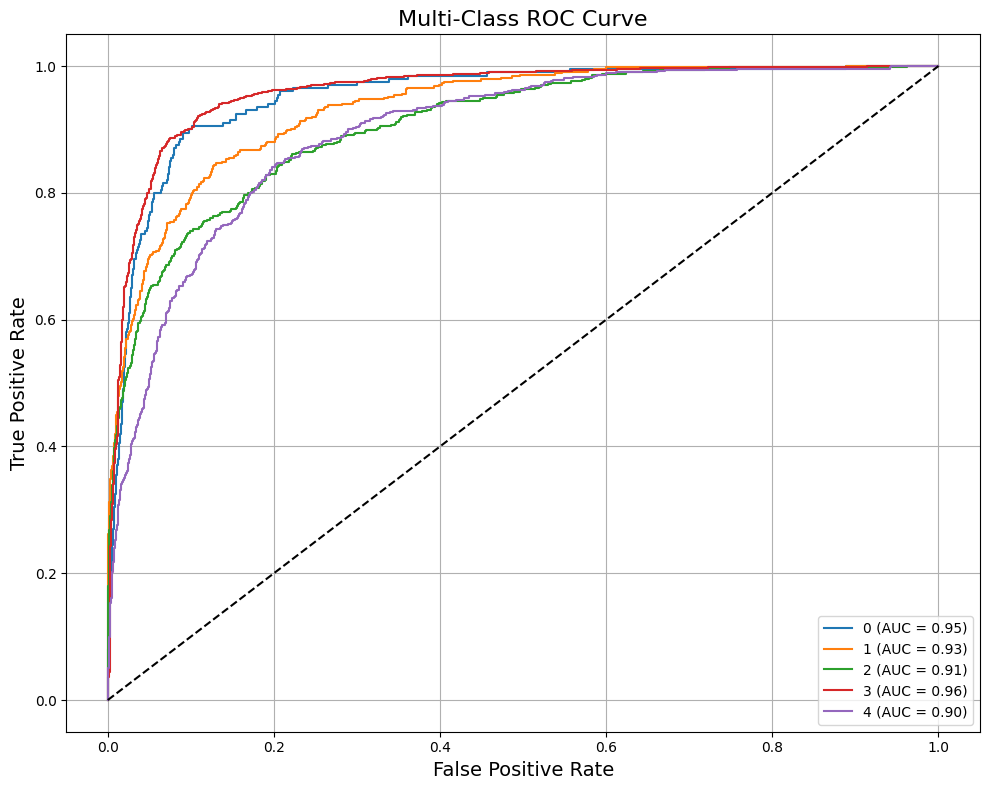

In [10]:
# Section 6: Evaluation and Metrics
val_preds, val_true = evaluate_model(model, validation_generator, validation_generator.class_indices)
plot_roc_curve(model, validation_generator, validation_generator.class_indices)